In [178]:
import pandas as pd
import numpy as np
import knnimpute
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.preprocessing import Imputer,StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
import matplotlib.pyplot as plt

In [90]:
data = pd.read_csv('House_Prediction_Data.csv')

In [91]:
data.shape

(1460, 81)

In [92]:
data.head()

,Id,SalePrice,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1,208500,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,2,181500,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,3,223500,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,4,140000,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,5,250000,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


In [93]:
data.loc[:, data.isnull().mean() < 0.8].shape

(1460, 77)

In [94]:
data = data.loc[:, data.isnull().mean() < .8]

In [95]:
data.shape

(1460, 77)

In [96]:
data.head()

,Id,SalePrice,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1,208500,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,...,61,0,0,0,0,0,2,2008,WD,Normal
1,2,181500,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,...,0,0,0,0,0,0,5,2007,WD,Normal
2,3,223500,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,...,42,0,0,0,0,0,9,2008,WD,Normal
3,4,140000,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,...,35,272,0,0,0,0,2,2006,WD,Abnorml
4,5,250000,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,...,84,0,0,0,0,0,12,2008,WD,Normal


In [97]:
data['Porch_Area'] = data['OpenPorchSF'] + data['EnclosedPorch'] + data['3SsnPorch'] + data['ScreenPorch']

In [98]:
data = data.drop(['OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch'], axis = 1)

In [99]:
data.shape

(1460, 74)

In [100]:
clf = LinearRegression()

In [101]:
temp = data[['SalePrice','LotFrontage', 'LotArea', 'OverallQual','OverallCond']]

In [102]:
data.dropna().shape

(583, 74)

In [146]:
#data_numeric = data._get_numeric_data()
data_numeric = data.select_dtypes(include=[np.number])

In [147]:
imp = Imputer(missing_values='NaN', strategy='median', axis=0)
data_numeric = pd.DataFrame(imp.fit_transform(data_numeric))

In [148]:
data_numeric.head()

,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,33,34
0,1.0,208500.0,60.0,65.0,8450.0,7.0,5.0,2003.0,2003.0,196.0,...,0.0,2003.0,2.0,548.0,0.0,0.0,0.0,2.0,2008.0,61.0
1,2.0,181500.0,20.0,80.0,9600.0,6.0,8.0,1976.0,1976.0,0.0,...,1.0,1976.0,2.0,460.0,298.0,0.0,0.0,5.0,2007.0,0.0
2,3.0,223500.0,60.0,68.0,11250.0,7.0,5.0,2001.0,2002.0,162.0,...,1.0,2001.0,2.0,608.0,0.0,0.0,0.0,9.0,2008.0,42.0
3,4.0,140000.0,70.0,60.0,9550.0,7.0,5.0,1915.0,1970.0,0.0,...,1.0,1998.0,3.0,642.0,0.0,0.0,0.0,2.0,2006.0,307.0
4,5.0,250000.0,60.0,84.0,14260.0,8.0,5.0,2000.0,2000.0,350.0,...,1.0,2000.0,3.0,836.0,192.0,0.0,0.0,12.0,2008.0,84.0


In [169]:
X= data_numeric.loc[:,2:35]
y = data_numeric.loc[:,1]

In [183]:
X_train,X_test, y_train,  y_test = train_test_split(X, y, test_size = 0.2, random_state = 123)

In [171]:
std_scale = StandardScaler().fit(X_train)
X_train_std = std_scale.transform(X_train)
X_test_std  = std_scale.transform(X_test)

In [172]:
data_numeric.iloc[:,1].head()

0    208500.0
1    181500.0
2    223500.0
3    140000.0
4    250000.0
Name: 1, dtype: float64

In [173]:
estimators = []
avg_error_all_models_nested_cv = []
std_error_all_models_nested_cv = []
avg_Rsquare_all_models_nested_cv = []
std_Rsquare_all_models_nested_cv = []

In [174]:
def nested_cv_evaluation(estimator_type, parameters, X_train, y_train):
    
    # set the number of iterations to do
    NUM_TRIALS = 5
    nested_scores_err = np.zeros(NUM_TRIALS)
    nested_scores_r2 = np.zeros(NUM_TRIALS)
    
    for i in range(NUM_TRIALS):
    
        # Choose cross-validation techniques for the inner and outer loops,
        # independently of the dataset.
        inner_cv = KFold(n_splits=3, shuffle=True, random_state=i)
        outer_cv = KFold(n_splits=5, shuffle=True, random_state=i)
    
        # Non_nested parameter search and scoring
        clf = GridSearchCV(estimator=estimator_type, 
                           param_grid=parameters, 
                           cv=inner_cv)
        clf.fit(X_train, y_train)

        # Nested CV with parameter optimization
        nested_score_error = cross_val_score(clf, X_train, y_train, cv=outer_cv, scoring='neg_mean_squared_error')
        nested_score_r2 = cross_val_score(clf, X_train, y_train, cv=outer_cv, scoring='r2')
        
        # Store values for reporting
        nested_scores_err[i] = nested_score_error.mean()
        nested_scores_r2[i] = nested_score_r2.mean()
         
    estimators.append(estimator_type)
    avg_error_all_models_nested_cv.append(nested_scores_err.mean())
    std_error_all_models_nested_cv.append(nested_scores_err.std())
    avg_Rsquare_all_models_nested_cv.append(nested_scores_r2.mean())
    std_Rsquare_all_models_nested_cv.append(nested_scores_r2.std())
    
    #std_all_models_nested_cv.append(nested_scores.std())
    print("Average error is {0} and standard deviation is {1}".format(nested_scores_err.mean(), nested_scores_err.std()))
    print("Average R-Square is {0} and standard deviation is {1}".format(nested_scores_r2.mean(), nested_scores_r2.std()))

In [180]:
def feature_selection_func(estimator, params, X_train, y_train):
    sfs1 = sfs(estimator, k_features='best', forward=True, floating=False, 
              scoring='neg_mean_squared_error', cv=10)

    sfs2 = sfs1.fit(X, y)
    fig = plot_sfs(sfs2.get_metric_dict(), kind='std_err')
    plt.title('Sequential Forward Selection (w. StdErr)')
    plt.grid()
    plt.show()
    print('Selected features:', sfs2.k_feature_idx_)
    X_train_sfs = sfs2.transform(X_train)
    X_test_sfs = sfs2.transform(X_test)
    nested_cv_evaluation(estimator, params, X_train_sfs, y_train)

In [184]:
param = {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False]}
lin_reg = LinearRegression()
nested_cv_evaluation(lin_reg, param, X_train, y_train)

Average error is -1714161858.4237628 and standard deviation is 150871928.14087546
Average R-Square is 0.7165937355592675 and standard deviation is 0.03734605441604239


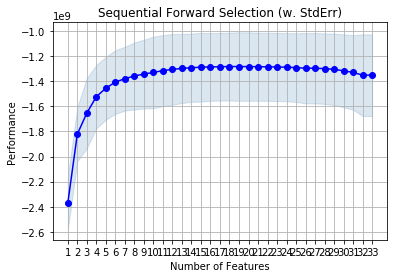

Selected features: (0, 2, 3, 4, 5, 6, 7, 8, 15, 16, 19, 20, 21, 22, 23, 24, 25, 27, 32)
Average error is -1535882467.2718868 and standard deviation is 107349104.84660858
Average R-Square is 0.7483300664206206 and standard deviation is 0.026864496187890507


In [185]:
# Linear Regression with feature selection
feature_selection_func(lin_reg, param, X_train, y_train)